Fetching data for GOOG from 2015-01-01 00:00:00 to 2024-07-25 05:49:39.522371


[*********************100%%**********************]  1 of 1 completed


Data extraction successful
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  26.378078  26.490770  26.133251  26.168653  26.138908  28951268
2015-01-05  26.091366  26.144720  25.582764  25.623152  25.594027  41196796
2015-01-06  25.679497  25.738087  24.983908  25.029282  25.000832  57998800
2015-01-07  25.280592  25.292759  24.914099  24.986401  24.958000  41301082
2015-01-08  24.831326  25.105074  24.482782  25.065184  25.036694  67071641
Data preprocessing successful
2345/2345 [==============================] - 95s 37ms/step - loss: 0.0025
Model training successful
1/1 [==============================] - 0s 31ms/step


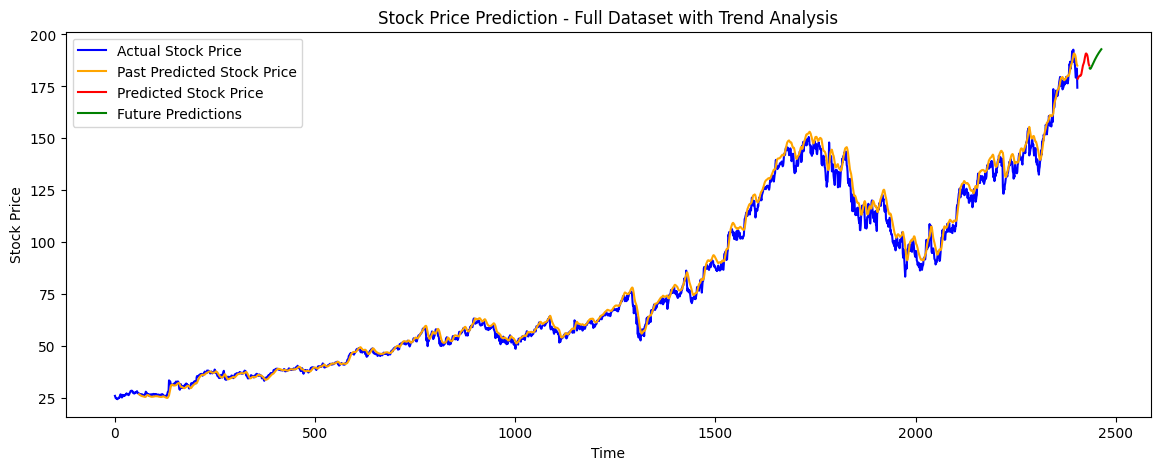

Prediction and visualization successful


In [18]:
# Import necessary libraries
import pandas_datareader as pdr
import yfinance as yf
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Step 1: Data Extraction using yfinance as alternative
# Define the stock and time period
stock = 'GOOG'
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime.now()

# Fetch the stock data using yfinance
print(f"Fetching data for {stock} from {start} to {end}")
data = yf.download(stock, start=start, end=end)
print("Data extraction successful")
print(data.head())  # Print the first few rows of the data for verification

# Step 2: Data Preprocessing
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Function to create time series sequences
def create_sequences(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Create sequences with a time step of 60 days
time_step = 60
X, Y = create_sequences(scaled_data, time_step)

# Reshape data for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
print("Data preprocessing successful")

# Step 3: LSTM Model Development
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, Y, epochs=1, batch_size=1)
print("Model training successful")

# Step 4: Prediction and Visualization
# Prepare test data for prediction
test_data = scaled_data[-(time_step + 30):]  # Get enough data for 30 days prediction
X_test, _ = create_sequences(test_data, time_step)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict the stock prices for the past data
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(train_predict)

# Predict the stock prices for the recent past and future
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Predict the next 30 days stock prices
future_predictions = []
last_60_days = scaled_data[-time_step:]

for _ in range(30):
    X_future = last_60_days[-time_step:].reshape((1, time_step, 1))
    future_price = model.predict(X_future)
    future_predictions.append(future_price[0, 0])
    last_60_days = np.append(last_60_days, future_price, axis=0)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Combine the actual data, past predictions, and future predictions for plotting
combined_data = data['Close'].tolist()
combined_data.extend([None] * (len(predictions) + len(future_predictions)))
combined_data = combined_data[:-len(future_predictions)]
past_predictions_list = [None] * time_step + train_predict.flatten().tolist() + [None] * (len(predictions) + len(future_predictions))
predictions_list = [None] * (len(combined_data) - len(predictions)) + predictions.flatten().tolist()
future_predictions_list = [None] * len(combined_data) + future_predictions.flatten().tolist()

# Plot the combined data
plt.figure(figsize=(14, 5))
plt.plot(combined_data, label='Actual Stock Price', color='blue')
plt.plot(past_predictions_list, label='Past Predicted Stock Price', color='orange')
plt.plot(predictions_list, label='Predicted Stock Price', color='red')
plt.plot(future_predictions_list, label='Future Predictions', color='green')
plt.title('Stock Price Prediction - Full Dataset with Trend Analysis')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Prediction and visualization successful")
